In [1]:

%%capture
!pip install faiss-cpu sentence-transformers langchain langchain_community langchain-huggingface langchain-ollama


In [3]:
import pandas as pd
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings

# Load your CSV dataset
df = pd.read_csv('/mnt/f/datasets/data.csv')

# Filter for valid full content
# texts = df['full_content'].dropna().sample(n=500, random_state=42).tolist()  # can adjust vectorstore with more than 100 articles 
texts = df['full_content'].dropna().sample(n=800, random_state=42).tolist() # use 800 articles in dataset

# Show how many articles we kept
print(f"Using {len(texts)} non-null articles for the vector store.")

# Initialize embeddings and build FAISS index
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = HuggingFaceEmbeddings(client=embedder)
vectorstore = FAISS.from_texts(texts, embeddings)


Using 800 non-null articles for the vector store.


/tmp/ipykernel_455018/3164190420.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(client=embedder)
/tmp/ipykernel_455018/3164190420.py:18: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings(client=embedder)


In [4]:
import networkx as nx
import spacy

nlp = spacy.load("en_core_web_sm")

G = nx.DiGraph()

def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subj = next((child for child in root.children if child.dep_ == "nsubj"), None)
        obj = next((child for child in root.children if child.dep_ in ["dobj", "pobj"]), None)
        if subj and obj:
            relationships.append((subj.text, root.lemma_, obj.text))
    return relationships

for text in texts:
    doc = nlp(text)
    triples = extract_relationships(doc)
    for subj, pred, obj in triples:
        G.add_edge(subj, obj, relation=pred)

print(f"Knowledge Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



Knowledge Graph has 4255 nodes and 5795 edges.


In [5]:
import faiss
import numpy as np

# 1. Format triples as text strings
triple_texts = [f"{s} —[{p}]→ {o}" for s, p, o in G.edges(data="relation")]

# 2. Embed triples using embedder
triple_embeddings = embedder.encode(triple_texts)

# 3. Build FAISS index
index = faiss.IndexFlatL2(triple_embeddings.shape[1])
index.add(np.array(triple_embeddings))

# 4. (Optional) Keep track of triples
triple_tuples = [(s, p, o) for s, o, p in G.edges(data="relation")]


In [6]:

from langchain_ollama import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = OllamaLLM(model="mistral")

krag_template = PromptTemplate(
    input_variables=["context", "triples", "question"],
    template="""
Context:
{context}

Knowledge Graph Triples:
{triples}

Question:
{question}

Answer:
""")

krag_chain = krag_template | llm | StrOutputParser()

rag_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Context:
{context}

Question:
{question}

Answer:
""")

rag_chain = rag_template | llm | StrOutputParser()

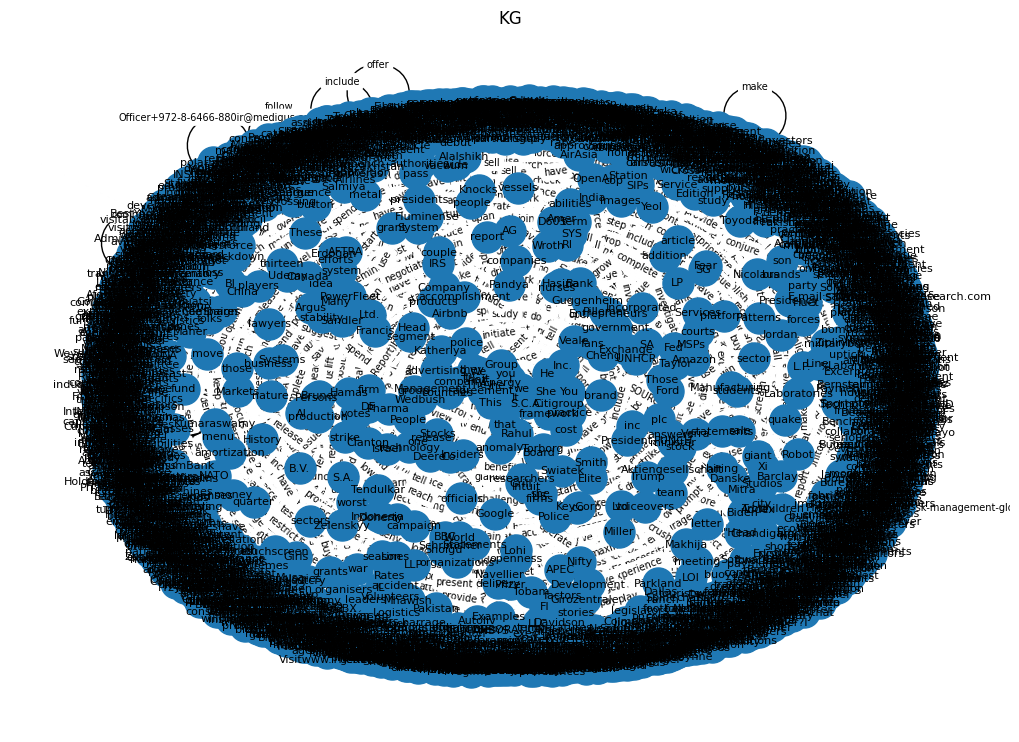

In [7]:
# show KG 
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("KG")
plt.show()

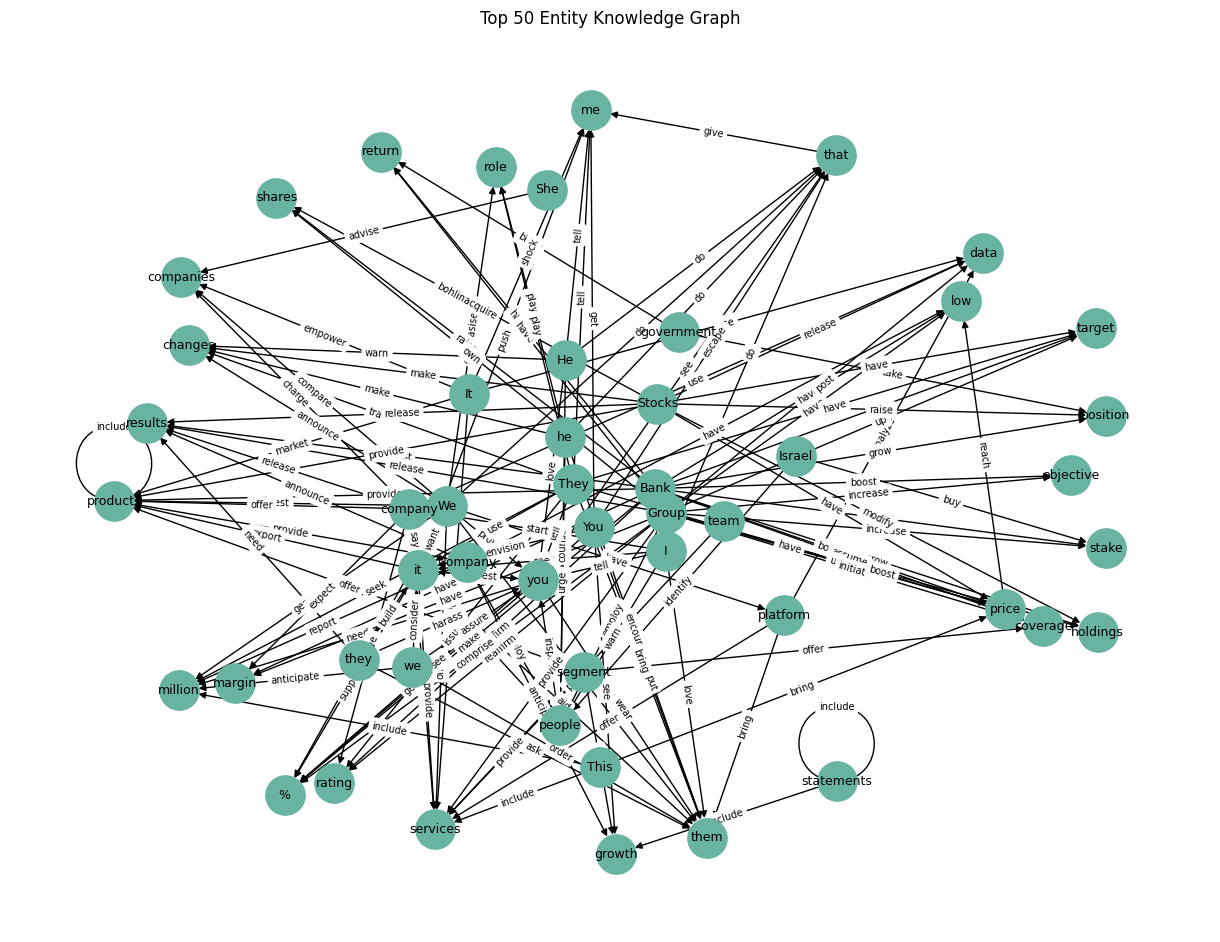

In [8]:
# Limit to top N nodes by degree (most connected)
N = 50
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:N]
subgraph = G.subgraph(top_nodes)

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subgraph, k=0.7)
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=9, node_color="#69b3a2")
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
plt.title("Top 50 Entity Knowledge Graph")
plt.axis('off')
plt.show()

In [9]:
# Format triples for LLM prompt
def format_triples(triples):
    return [f"{s} —[{p}]→ {o}" for s, p, o in triples]

# Score recall based on how many ground truth triples are reflected in the answer for KRAG 
def score_recall_KRAG(triples, answer):
    total_parts = 0
    matched_parts = 0
    for s, p, o in triples:
        for part in [s, p, o]: # GT Subject, predicate, and object 
            total_parts += 1
            if part.lower() in answer.lower(): # if the subject, predicate, and object ground truth appear in LLM answer, then increment recall score
                # print("triple used: ", part.lower())
                matched_parts += 1
    # print("Triple Count:", matched_parts) # threshold 
    return matched_parts / total_parts if total_parts else 0, matched_parts # matched_parts for triples found 

# Score recall based on how well ground truth context is reflected in the answer for RAG 
def score_recall_RAG(context, answer): 
    # print("number of words in context also in answer: ", sum(1 for word in answer.split() if word.lower() in context.lower())) # threshold 
    return sum(1 for word in answer.split() if word.lower() in context.lower()) / len(answer.split())
    
# Retrieve documents and generate an answer with context
def rag_query(question, k = 5): # can change RAG K 
    # search vectorstore for embedded text chunks from dataset (articles, reports, etc.)
    # retrieve K most semantically similar chunks, contatenate into string, input to LLM with question 
    docs = vectorstore.similarity_search(question, k=k) 
    context = "\n".join([doc.page_content for doc in docs])
    answer = rag_chain.invoke({"context": context, "question": question}).strip()
    return answer, context


def krag_query(question, k=5): # K controls how many triples are retrieved from KG.Pulling too many triples can dilute quality. 5 triples per question 
    # Embed the question and retrieve top-k triples from FAISS
    q_embed = embedder.encode([question])
    _, I = index.search(np.array(q_embed), k)
    
    # Get the matching triples 
    # print("retrieving ", k, " triples from KG for Ground Truth"); 
    
    retrieved_triples = [triple_tuples[i] for i in I[0]] # can we retrieve more triples? 
    triples_text = "\n".join(format_triples(retrieved_triples))

    # Retrieve vectorstore context as usual - this makes KRAG a hybrid, uses context and Triples. We can change to just triples later to test 
    # context = "\n".join([doc.page_content for doc in vectorstore.similarity_search(question, k=k)]) # limit context to max 5 chunks if we pull a huge context by changing K  
    context = "" # KRAG should only rely on KG, not context 
    # Run the LLM with context and embedding-retrieved triples
    # print("Ground Truth Triples:", retrieved_triples)
    answer = krag_chain.invoke({"context": context, "triples": triples_text, "question": question}).strip()

    return answer, retrieved_triples



In [10]:
# Generate sample questions based on entities in KG 
# sample_entities = list(G.nodes())[:10]
fifty_entities = list(G.nodes())[:50] # use 50 available KG entities 

questions = [f"What does {entity} do?" for entity in fifty_entities]

# Optionally preview them
# for q in questions:
#     print("-", q)


In [11]:
evals = [] 

for q in questions:
    # print(f"Question: {q}")

    rag_answer, rag_context = rag_query(q)
    krag_answer, ground_truth = krag_query(q)

    krag_recall, triples_found = score_recall_KRAG(ground_truth, krag_answer)
    rag_recall = score_recall_RAG(rag_context, rag_answer)

    # print(f"  RAG Answer:  {rag_answer}")
    # print(f"  kRAG Answer: {krag_answer}")

    # recall logging 
    # print(f"  KRAG Recall from triples: {krag_recall:.2f}\n")
    # print(f"  RAG Recall from context: {rag_recall:.2f}\n")

    rag_match_words = sum(1 for word in rag_answer.split() if word.lower() in rag_context.lower())

    evals.append({
        "question": q,
        "triples": triples_found,
        "krag_recall": krag_recall,
        "rag_match_words": rag_match_words,
        "rag_recall": rag_recall
    })

# convert evals to df for graphing 
df = pd.DataFrame(evals)

### So now a good thing to graph would be how the triples found in ground truth increases the KRAG recall and how the number of words in context that are also in answer increase the RAG recall to see the influence of both 

### We can see here that 5 triples found in ground truth does not increase KRAG recall above RAG recall by a significant margin, but when we find 9 triples in ground truth we near RAG recall with 60%

### As the number of retrieved triples increases, KRAG's recall improves and begins to rival or surpass RAG — depending on how well those triples cover the answer space 

### Is there a triple threshold where KRAG surpasses RAG recall? 

# 1st graph 
The number of triples in the answer increases the KRAG Recall 

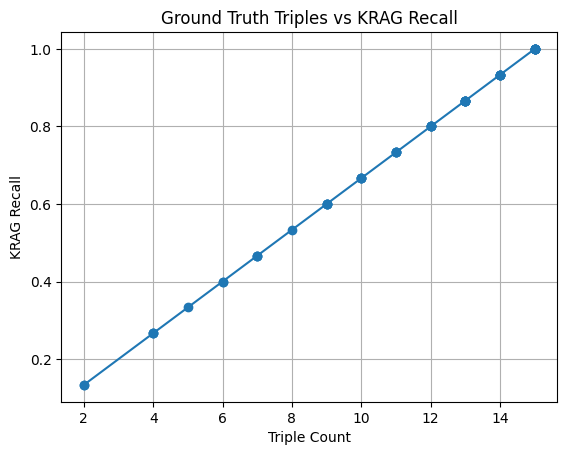

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(evals)

# sort df's for KRAG and RAG 
df_krag = df.sort_values(by="triples", ascending=True)
df_rag = df.sort_values(by="rag_match_words", ascending=True)


# Plot 1: Ground Truth Triples vs KRAG Recall
plt.plot(df_krag["triples"], df_krag["krag_recall"], marker="o")
plt.title("Ground Truth Triples vs KRAG Recall")
plt.xlabel("Triple Count")
plt.ylabel("KRAG Recall")
plt.grid(True)
plt.show()

# 2nd graph 
Matching more words is good — but only if the answer stays tight and grounded.

Longer, wordier answers can dilute recall — even if they pull more correct words from context.

RAG recall measures precision of the answer relative to its source, not total coverage

Fighting hallucination 

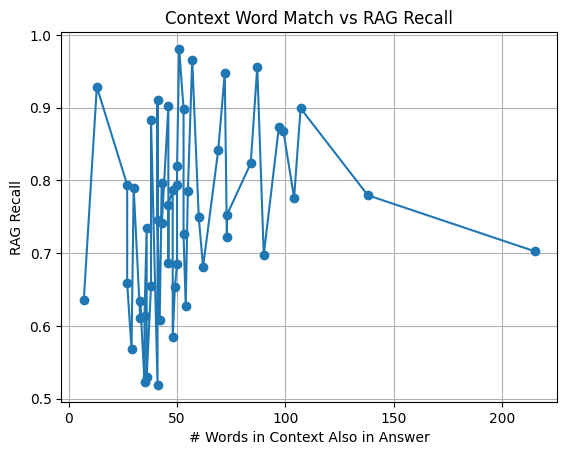

In [13]:
# Plot 2: Context Match Words vs RAG Recall
plt.plot(df_rag["rag_match_words"], df_rag["rag_recall"], marker="o")
plt.title("Context Word Match vs RAG Recall")
plt.xlabel("# Words in Context Also in Answer")
plt.ylabel("RAG Recall")
plt.grid(True)
plt.show()


### Spreadof 0.6 - 1 

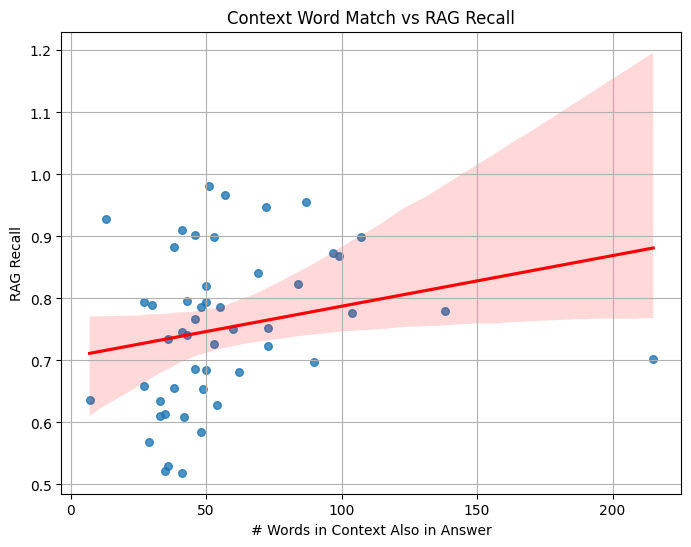

In [14]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(x="rag_match_words", y="rag_recall", data=df_rag, scatter_kws={"s":30}, line_kws={"color":"red"})
plt.title("Context Word Match vs RAG Recall")
plt.xlabel("# Words in Context Also in Answer")
plt.ylabel("RAG Recall")
plt.grid(True)
plt.show()

# 3rd graph 

KRAG Recall threshold of 0.4? 

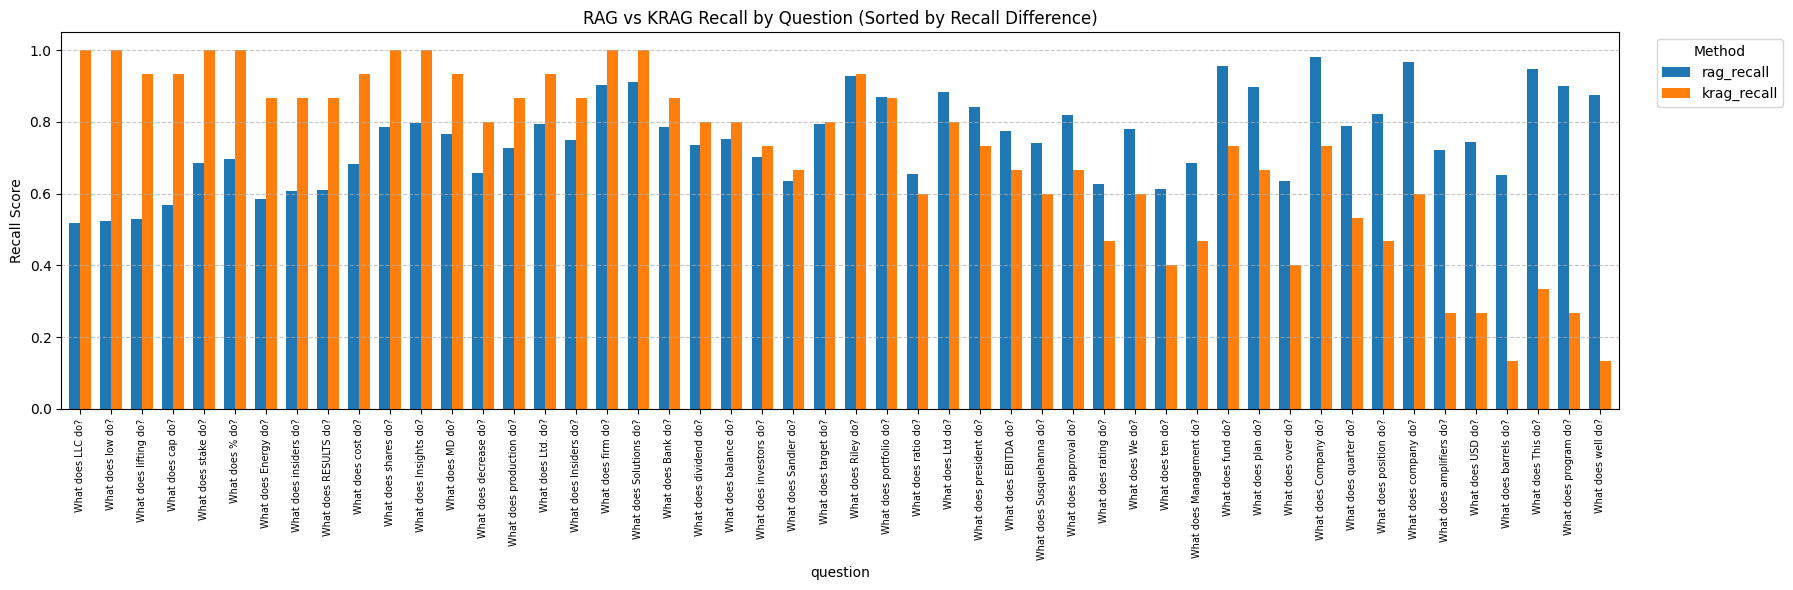

In [16]:
import matplotlib.pyplot as plt

# Calculate recall difference for sorting
df["recall_diff"] = df["krag_recall"] - df["rag_recall"]
df_sorted = df.sort_values(by="recall_diff", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(18, 6))  # Make it wider
df_sorted.plot(
    x="question",
    y=["rag_recall", "krag_recall"],
    kind="bar",
    ax=ax,
    width=0.7,
)

plt.title("RAG vs KRAG Recall by Question (Sorted by Recall Difference)")
plt.ylabel("Recall Score")
plt.ylim(0, 1.05)  # Uniform y-axis
plt.xticks(rotation=90, ha="center", fontsize=7)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


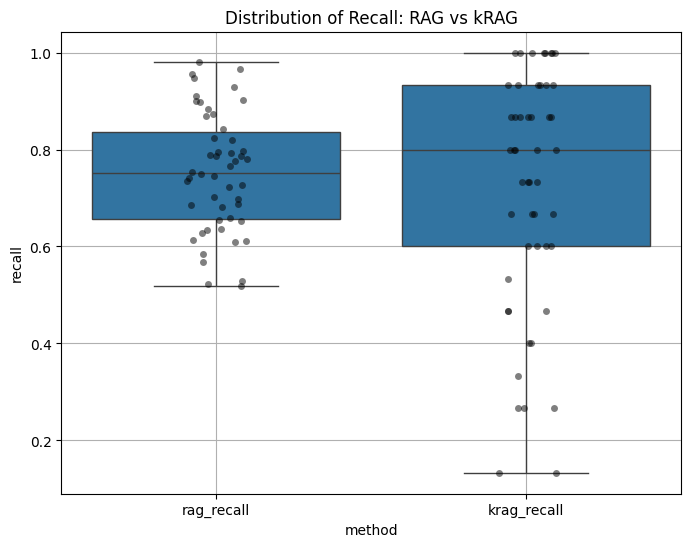

In [17]:
# ttest to compare recall 
import matplotlib.pyplot as plt

df_melted = df.melt(id_vars=["question"], value_vars=["rag_recall", "krag_recall"], var_name="method", value_name="recall")

plt.figure(figsize=(8,6))
import seaborn as sns
# Individual questions with boxplot 
sns.boxplot(x="method", y="recall", data=df_melted)
sns.stripplot(x="method", y="recall", data=df_melted, color="black", alpha=0.5)
plt.title("Distribution of Recall: RAG vs kRAG")
plt.grid(True)
plt.show()

1. Y-axis is correct — it is recall.
So yes, setting value_name="recall" in df.melt() is correct.

It tells readers: we are plotting recall scores.

2. Interpret the boxes:
The middle line of each box = the median recall

The box edges = the 25th and 75th percentiles

The whiskers = spread of recall values

### Observations 

RAG recall (left):

Tighter box (less spread)

Median around 0.75

KRAG recall (right):

Wider box (more spread)

Median a little higher (closer to ~0.8)

Big number of low outliers (lots of poor scores)



In [19]:
# Paired Ttest 
from scipy.stats import ttest_rel

statistic, p_value = ttest_rel(df["krag_recall"], df["rag_recall"])

print(f"t-statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

t-statistic: -0.8806
p-value: 0.3828


## t-statistic: Negative 

T stat measures mean, so KRAG's mean is pulled down with outliers 

RAG recall slightly higher than KRAG recall 

## P value - No signficant difference  

P < 0.05 - Significant Improvement from KRAG 

P >= 0.05 - Minimal Improvement 

## Future Improvements 

KRAG HYBRID = KG + CONTEXT 